<a href="https://colab.research.google.com/github/UdayBhaskarDS/Pneumonia-detection-using-deep-learning/blob/main/Pneumonia_Image_classification_with_Transfer_learning_Inception_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.models import Model
#from keras.optimizers import Adam
from keras.optimizers import adam_v2


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#! unzip ../input/aerial-cactus-identification/train.zip -d ../input/aerial-cactus-identification/

In [5]:
class_info = pd.read_csv('/content/drive/MyDrive/Pneumonia_Detection/stage_2_detailed_class_info.csv')
tr_labels = pd.read_csv('/content/drive/MyDrive/Pneumonia_Detection/stage_2_train_labels.csv')



In [6]:
print(len(class_info))
class_info.head()

30227


,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [7]:
class_info['class'].unique()

array(['No Lung Opacity / Not Normal', 'Normal', 'Lung Opacity'],
      dtype=object)

In [8]:
#The list of class names for which label binarizer is run
class_names = ['No Lung Opacity / Not Normal', 'Normal', 'Lung Opacity']

In [9]:
images_list = os.listdir("/content/drive/MyDrive/Pneumonia_Detection/stage_2_train_images")
test_image = os.listdir("/content/drive/MyDrive/Pneumonia_Detection/stage_2_test_images")

In [10]:
path="/content/drive/MyDrive/Pneumonia_Detection/stage_2_train_images/"

In [11]:
!pip install pydicom


In [12]:
!pip install scipy

In [13]:
import pydicom
import skimage.io
import skimage.transform

from skimage.transform import resize


In [14]:

#channels = 3 ==> RGB or HSV images, channels = 1 ==> Greyscale images
channels = 1

#Normalization value should be 255 for RGB or Greyscale images. It should be 1 for HSV images.
normalizationVal = 255.0


In [17]:
#Other parameters
epochs = 20
batchsize = 32
learningRate = 0.001
monitorVariable = 'val_categorical_accuracy'
monitorMode = 'max'

In [16]:
train_x=[]
train_y=[]
def makeDataset():
    for i in range(len(images_list)%1500):
        d=pydicom.read_file(path+images_list[i])
        c=class_info[class_info['patientId']==images_list[i][:-4]]
        d = skimage.transform.resize(d.pixel_array,(150,150,channels))
        new_image_data = d.reshape((1, 150, 150, channels)).astype(np.float32) / normalizationVal
        train_y.append(c['class'].unique()[0])
        train_x.append(new_image_data)
makeDataset()

In [18]:
train_x = np.reshape(train_x,(np.size(train_y),150,150,channels))
train_y = np.reshape(train_y,(np.size(train_y),1))


In [19]:
print(train_x.shape)
print(train_y.shape)

(1184, 150, 150, 1)
(1184, 1)


In [20]:
from sklearn.preprocessing import label_binarize

train_y = label_binarize(train_y, classes = class_names)


In [21]:
print(train_y.shape)

(1184, 3)


In [22]:
from keras.optimizers import adam_v2
optimizer = adam_v2.Adam()

In [23]:
batch_size = 32
nb_epoch = 20

In [25]:
#loading the inception v3 model
from keras.applications.inception_v3 import InceptionV3
# # load model
# model = InceptionV3()
# # summarize the model
# model.summary()
img_input = tf.keras.layers.Input(shape=(150, 150,1))
img_conc = tf.keras.layers.Concatenate()([img_input, img_input, img_input])    
#img_conc = np.dstack((img_input, img_input, img_input))

In [26]:
# load model without classifier layers
model = InceptionV3(include_top=False, weights='imagenet',input_tensor=img_conc)
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(300, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 150, 150, 3)  0           input_1[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         concatenate[0][0]                
______________________________________________________________________________________________

In [27]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [28]:

history = model.fit(train_x, train_y,
              batch_size=batch_size,
              epochs=nb_epoch)

Epoch 1/20
37/37 [==============================] - 264s 7s/step - loss: 2.7423 - accuracy: 0.5971
Epoch 2/20
37/37 [==============================] - 253s 7s/step - loss: 0.6042 - accuracy: 0.7525
Epoch 3/20
37/37 [==============================] - 252s 7s/step - loss: 0.4745 - accuracy: 0.8167
Epoch 4/20
37/37 [==============================] - 251s 7s/step - loss: 0.4441 - accuracy: 0.8404
Epoch 5/20
37/37 [==============================] - 246s 7s/step - loss: 0.3800 - accuracy: 0.8488
Epoch 6/20
37/37 [==============================] - 247s 7s/step - loss: 0.4127 - accuracy: 0.8378
Epoch 7/20
37/37 [==============================] - 248s 7s/step - loss: 0.3156 - accuracy: 0.8742
Epoch 8/20
37/37 [==============================] - 248s 7s/step - loss: 0.2441 - accuracy: 0.9206
Epoch 9/20
37/37 [==============================] - 250s 7s/step - loss: 0.3612 - accuracy: 0.8682
Epoch 10/20
37/37 [==============================] - 250s 7s/step - loss: 0.3801 - accuracy: 0.8547
Epoch 11/

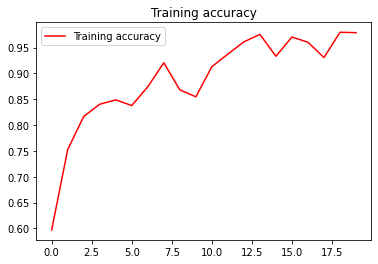

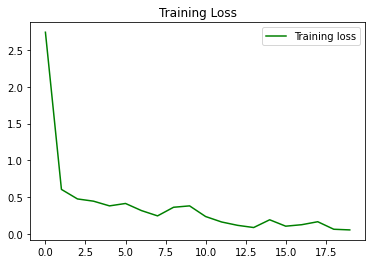

In [29]:
# Model Training Results
accuracy = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.title('Training accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'g', label='Training loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [30]:
def label(s):
    if s=='Normal':
        return 0
    if s=='No Lung Opacity / Not Normal':
        return 1
    if s=='Lung Opacity':
        return 2

In [41]:
def check(i):
    dcm_img = pydicom.read_file(path+class_info.loc[i][0]+".dcm")
    img=dcm_img.pixel_array
    d = skimage.transform.resize(img,(150,150,channels))
    new_image_data = d.reshape((1, 150, 150, channels)).astype(np.float32) / normalizationVal
    plt.figure(figsize=(10,10))
    plt.imshow(img,cmap='gray')
    p=np.argmax(np.round(model.predict(new_image_data)))
    plt.title("Predicted {} ,Actual {}".format(p,label(class_info.loc[i][1])))
    plt.show()

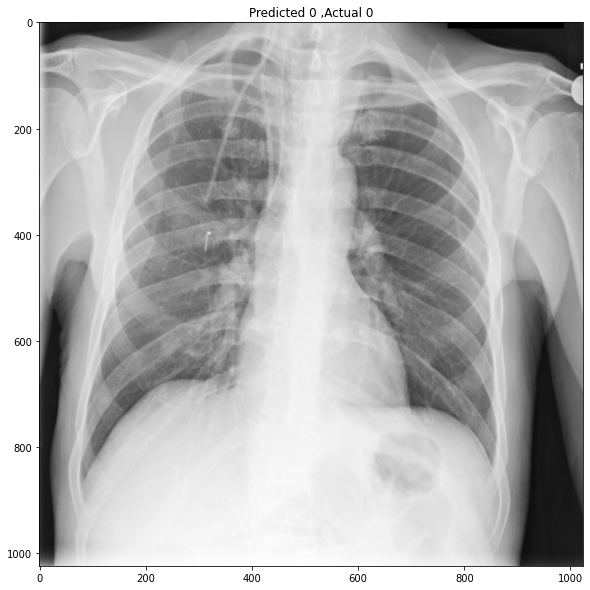

In [42]:
check(25000)